# Representation learning and predictive analysis for Football managers

In this chapter we are going to try to model members of the amateur football club. This is related to one of the author's contributions to a wellbeing of a local football community. The ultimate goal is to split membors into a reasonable teams so that it is as enjoyable and competitive from sport's perspoective as possible.

## The challenge

For every Sunday's game we organise a poll to see who is joining a game. Coomon agreement is that we need minimum 10 and maximum 18 players - so it means we have a variable size teams.

- even though we have started to collect data for our game we still have around 20 games recorded. Distribution of the players also changed over the course of the recoring period so we have even less data for every single player. 

## The plan


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, initializers
from datetime import date
import numpy as np
import os

    
from competition_manager import *

In [2]:
import random


def set_seed(seed=42):
    np.random.seed(seed)                  # Fix NumPy random seed
    random.seed(seed)                     # Fix Python built-in random seed
    tf.random.set_seed(seed)              # Fix TensorFlow random seed

    # Optional but recommended: configure TensorFlow for deterministic ops
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Call this function at the very start, before building or training your model
seed_value = 42
set_seed(seed_value)

## Generate synthetic teams and games

### Calculating team's strength based on players individual strengths and rule-based interactions 

In [3]:
def calculate_team_strength(team_players):
    # Base strength sum
    strength = player_strengths[team_players].sum()
    print(f"Base strength of team {team_players}: {strength:.4f}")
    
    # Compute favorite player boost (fixed)
    for i, pair in enumerate(friend_pairs):
        if all(player in team_players for player in pair):
            boost = friend_pairs_boost[i]
            strength += boost
            print(f"Favorite pair boost applied for players {pair}: +{boost:.4f}, total strength now {strength:.4f}")
    for i, triplet in enumerate(friend_triplets):
        if all(player in team_players for player in triplet):
            boost = friend_triplets_boost[i]
            strength += boost
            print(f"Favorite triplet boost applied for players {triplet}: +{boost:.4f}, total strength now {strength:.4f}")
    
    # Compute skills boost correlated with players' average strength
    for i, pair in enumerate(skilled_pairs):
        if all(player in team_players for player in pair):
            avg_strength = player_strengths[list(pair)].mean()
            boost = skilled_pairs_boost[i] * avg_strength
            strength += boost
            print(f"Skills pair boost for players {pair}: avg strength {avg_strength:.4f} * boost factor {skilled_pairs_boost[i]:.4f} = +{boost:.4f}, total strength now {strength:.4f}")
    
    for i, triplet in enumerate(skilled_triplets):
        if all(player in team_players for player in triplet):
            avg_strength = player_strengths[list(triplet)].mean()
            boost = skilled_triplets_boost[i] * avg_strength
            strength += boost
            print(f"Skills triplet boost for players {triplet}: avg strength {avg_strength:.4f} * boost factor {skilled_triplets_boost[i]:.4f} = +{boost:.4f}, total strength now {strength:.4f}")
    
    return strength

### Generating the teams, friend pairs/triplets and skills pairs/triplets

In [4]:
np.random.seed(42)  # for reproducibility

NUM_PLAYERS = 30  # player 0 is ignore/masked and 1 is added to account for this
MIN_TEAM_SIZE = 5
MAX_TEAM_SIZE = 9
NUM_GAMES = 100

# 1. Generate players' strengths: single float number [0, 1]
player_strengths = np.random.rand(NUM_PLAYERS + 1) # player 0 is ignore/masked 

# 2. Generate favorite player pairs and triplets (friends)
num_friend_pairs = 10
num_friend_triplets = 5

# Randomly select unique pairs
friend_pairs = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS +1), size=2, replace=False)) for _ in range(num_friend_pairs)]
friend_pairs_boost = np.random.uniform(0.05, 0.15, size=num_friend_pairs)  # small boost

# Randomly select unique triplets
friend_triplets = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS +1), size=3, replace=False)) for _ in range(num_friend_triplets)]
friend_triplets_boost = np.random.uniform(0.1, 0.25, size=num_friend_triplets)  # larger boost

# 3. Generate skilled pairs and triplets (high skill synergy)
num_skilled_pairs = 8
num_skilled_triplets = 4

skilled_pairs = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS + 1), size=2, replace=False)) for _ in range(num_skilled_pairs)]
skilled_pairs_boost = np.random.uniform(0.1, 0.2, size=num_skilled_pairs)  # moderate boost

skilled_triplets = [tuple(np.random.choice(np.arange(1, NUM_PLAYERS + 1), size=3, replace=False)) for _ in range(num_skilled_triplets)]
skilled_triplets_boost = np.random.uniform(0.15, 0.3, size=num_skilled_triplets)  # strong boost

# 2. Prepare arrays to hold the dataset
teamA_data = np.zeros((NUM_GAMES, MAX_TEAM_SIZE), dtype=int)
teamB_data = np.zeros((NUM_GAMES, MAX_TEAM_SIZE), dtype=int)
labels = np.zeros(NUM_GAMES)

def drop_zeroes_for_sum(players_strengths):
    return players_strengths[players_strengths !=0]

for game_i in range(NUM_GAMES):
    # Random sizes for both teams in [MIN_TEAM_SIZE, MAX_TEAM_SIZE]

    team_size = np.random.randint(MIN_TEAM_SIZE, MAX_TEAM_SIZE + 1)

    # Randomly sample distinct players for each team (sampling with replacement allowed for simplicity)
    # To avoid overlap if needed: sample without replacement from full 32 for both teams combined,
    # here assuming players can appear on both teams (as per original conversation)
    # teamA_players = np.random.choice(NUM_PLAYERS, size=teamA_size, replace=False)
    # teamB_players = np.random.choice(NUM_PLAYERS, size=teamB_size, replace=False)
    
    # Shuffle all players and split into two disjoint teams
    all_players = np.random.permutation(np.arange(1, NUM_PLAYERS + 1))
    teamA_players = all_players[:team_size]
    teamB_players = all_players[team_size:2*team_size]
    
    print(f"Game # {game_i} evaluation: ")
    # Compute team strengths as sum of player strengths
    teamA_strength = calculate_team_strength(teamA_players)
    teamB_strength = calculate_team_strength(teamB_players)
    print(f"=" * 50)
    
    # print(f"Team A strengths {player_strengths[teamA_players]} Total: {teamA_strength}")

    # Calculate match outcome: 1 if Team A wins, 0 if Team B wins
    # Add small noise to simulate unpredictability
    outcome = teamA_strength - teamB_strength + np.random.normal(scale=0.1)
    labels[game_i] = outcome

    # Pad teams to max size using zeros (which corresponds to masked player)
    teamA_data[game_i, :team_size] = teamA_players
    teamB_data[game_i, :team_size] = teamB_players

print("player_strengths shape:", player_strengths.shape)
print("teamA_data shape:", teamA_data.shape)
print("teamB_data shape:", teamB_data.shape)
print("labels shape:", labels.shape)

# Example print first 3 games
for i in range(3):
    print(f"Game {i}:")
    teamA_pls = teamA_data[i]
    print(" Team A players: ", teamA_pls)
    print(" Team A palyers' stregths: ", player_strengths[teamA_pls])

    teamB_pls = teamB_data[i]
    print(" Team B players: ", teamB_pls)
    print(f"Team B strengths {drop_zeroes_for_sum(player_strengths[teamB_pls]).sum()}")
    print(" Team B palyers' stregths: ", player_strengths[teamB_pls])
    print(" Label (Team A wins=1):", labels[i])


Game # 0 evaluation: 
Base strength of team [ 4  8 19 24 23  3 26  7 25]: 4.3205
Base strength of team [30 15 16 27 11 13 29 20 17]: 3.9747
Favorite pair boost applied for players (np.int64(30), np.int64(20)): +0.0999, total strength now 4.0747
Favorite pair boost applied for players (np.int64(11), np.int64(15)): +0.1495, total strength now 4.2241
Skills pair boost for players (np.int64(20), np.int64(11)): avg strength 0.7909 * boost factor 0.1480 = +0.1171, total strength now 4.3412
Game # 1 evaluation: 
Base strength of team [16  9 21  4  5  1  8 17  6]: 3.5985
Favorite pair boost applied for players (np.int64(16), np.int64(4)): +0.1072, total strength now 3.7057
Favorite pair boost applied for players (np.int64(16), np.int64(8)): +0.1269, total strength now 3.8325
Base strength of team [10 26 12 11 30 18 28  3  7]: 5.1193
Skills pair boost for players (np.int64(10), np.int64(12)): avg strength 0.4265 * boost factor 0.1377 = +0.0587, total strength now 5.1781
Game # 2 evaluation: 
Ba

## Building a model

In [5]:

# Constants (adjust as needed)
PLAYER_EMB_DIM = 32
# NUM_CLASSES = 1  # Binary: win/loss

# Inputs: variable-length teams
teamA_input = Input(batch_shape=(80, 9), dtype='int32', name='teamA')  # variable-length
teamB_input = Input(batch_shape=(80, 9), dtype='int32', name='teamB')  # variable-length

# Embedding layer with mask support
player_embedding = layers.Embedding(
    input_dim=NUM_PLAYERS + 1,
    output_dim=PLAYER_EMB_DIM,
    embeddings_initializer=initializers.GlorotUniform(seed=seed_value),
    mask_zero=True,  # Important: enables automatic masking for padding (0 as pad token)
    # embeddings_regularizer=tf.keras.regularizers.l2(1e-4),
    name='player_embedding'
)

# Embed team players
teamA_embeds = player_embedding(teamA_input)  # shape: (batch, teamA_len, emb_dim)
teamB_embeds = player_embedding(teamB_input)

#Self-attention block (respects masks automatically if using Functional API)
def self_attention_block(x, name_prefix=''):
    attn_output = layers.MultiHeadAttention(
        num_heads=4,
        key_dim=PLAYER_EMB_DIM,
        dropout=0.1,
        name=f'{name_prefix}_attn'
    )(x, x)
    x = layers.Add(name=f'{name_prefix}_residual')([x, attn_output])
    x = layers.LayerNormalization(name=f'{name_prefix}_norm')(x)
    return x

# # Apply attention
teamA_attn = self_attention_block(teamA_embeds, 'teamA')
teamB_attn = self_attention_block(teamB_embeds, 'teamB')

# Global average pooling over valid (non-padded) tokens
# TF handles masking automatically in GlobalAveragePooling1D if mask_zero=True
teamA_vector = layers.GlobalAveragePooling1D(name='teamA_avgpool')(teamA_attn)
teamB_vector = layers.GlobalAveragePooling1D(name='teamB_avgpool')(teamB_attn)
teamA_vector = teamA_vector
teamB_vector = teamB_vector 

# Matchup modeling (difference vector)
matchup_vector = layers.Subtract(name='matchup_diff')([teamA_vector, teamB_vector])

# Concatenate summary representation
match_input = layers.Concatenate(name='match_features')([teamA_vector, teamB_vector, matchup_vector])
# match_input = layers.Concatenate(name='match_features')([teamA_vector, teamB_vector])

# Feedforward classification head
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(match_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='linear', name='regression_output')(x)

# Final model
model = Model(inputs=[teamA_input, teamB_input], outputs=output)
model.compile(optimizer='adam', 
                loss='mean_squared_error',   # or 'mean_absolute_error'
                metrics=['mean_absolute_error']
                )

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ teamA (InputLayer)  │ (80, 9)           │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB (InputLayer)  │ (80, 9)           │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (80, 9, 32)       │        992 │ teamA[0][0],      │
│ (Embedding)         │                   │            │ teamB[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (80, 9)           │          0 │ teamA[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (80, 9)           │          0 │ teamB[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_attn          │ (80, 9, 32)       │     16,800 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_attn          │ (80, 9, 32)       │     16,800 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
│                     │                   │            │ not_equal_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_residual      │ (80, 9, 32)       │          0 │ player_embedding… │
│ (Add)               │                   │            │ teamA_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_residual      │ (80, 9, 32)       │          0 │ player_embedding… │
│ (Add)               │                   │            │ teamB_attn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_norm          │ (80, 9, 32)       │         64 │ teamA_residual[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or          │ (80, 9)           │          0 │ not_equal[0][0],  │
│ (LogicalOr)         │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_norm          │ (80, 9, 32)       │         64 │ teamB_residual[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_1        │ (80, 9)           │          0 │ not_equal_1[0][0… │
│ (LogicalOr)         │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamA_avgpool       │ (80, 32)          │          0 │ teamA_norm[0][0], │
│ (GlobalAveragePool… │                   │            │ logical_or[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ teamB_avgpool       │ (80, 32)          │          0 │ teamB_norm[0][0], │
│ (GlobalAveragePool… │                   │            │ logical_or_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ matchup_diff        │ (80, 32)          │          0 │ teamA_avgpool[0]… │
│ (Subtract)          │                   │            │ teamB_avgpool[0]

 Total params: 43,041 (168.13 KB)

 Trainable params: 43,041 (168.13 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assume the following arrays from your dataset generation code:
# teamA_data, teamB_data, labels (all np arrays)

# 1. Train-validation split (80% train, 20% validation)
X_trainA, X_valA, X_trainB, X_valB, y_train, y_val = train_test_split(
    teamA_data, teamB_data, labels, test_size=0.2, random_state=42
)

# 2. Build or import your Keras model (reuse the model creation code from before)
# For example, let's say you have your variable-size team transformer model as 'model'

# 3. Optional: callbacks for monitoring
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a learning rate schedule function (step decay example)
def lr_schedule(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10
    if epoch > 0 and epoch % epochs_drop == 0:
        return lr * drop_rate
    return lr

#Instantiate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Or adaptive reduction on plateau (reduce LR when val_loss stalls)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=5, min_lr=1e-6)


player_embedding_layer = model.get_layer("player_embedding")
embeddings_before_fold = player_embedding_layer.get_weights()[0]
print("Embedding vector for player zero before training:", embeddings_before_fold[0])

print(X_trainA)

# 4. Train the model
history = model.fit(
    [X_trainA, X_trainB],                 # Inputs as a list
    y_train,                              # Targets
    epochs=50,
    batch_size=32,
    validation_data=([X_valA, X_valB], y_val),
    callbacks=[lr_scheduler, reduce_lr, early_stop],
    # callbacks=[early_stop]
)

pe_layer = model.get_layer("player_embedding")
embeddings_after_fold = pe_layer.get_weights()[0]
print("Embedding vector for player zero after training:", embeddings_after_fold[0])

change = np.linalg.norm(embeddings_after_fold[0] - embeddings_before_fold[0])
print("Change in player zero embedding vector:", change)

# 5. Evaluate model performance
loss, accuracy = model.evaluate([X_valA, X_valB], y_val)
print(f"Validation accuracy: {accuracy:.3f}")

Embedding vector for player zero before training: [-0.13428518 -0.0009771   0.1329839  -0.29613775 -0.26009488  0.07811415
  0.15738839 -0.20170173 -0.22916353 -0.27609777  0.27313498 -0.16636868
 -0.01386166 -0.1564296   0.13861132  0.16607106  0.02278191 -0.20447966
  0.00173342 -0.18519947 -0.28682098 -0.11555447 -0.01580417  0.03690901
  0.1996915   0.05639273 -0.11093217  0.16203171 -0.23099054  0.06050453
 -0.12172711  0.21778926]
[[15 19 17 25 24  7 30 14  0]
 [20 18 25 13  5 10 15  2  0]
 [15 27 12 29 19  2 14  0  0]
 [13 29 18 24  4 30 16 20  0]
 [22 18 13 25  1 26 12  2  0]
 [ 7  8 21 28 25 13  0  0  0]
 [ 6 25 13  7  2 16  0  0  0]
 [25 23 21 24 17 28  1 10  0]
 [ 7 16 19 28 21 17  3  4  0]
 [30  8  7 16 12 13 10 19  0]
 [19 27 10 15 13 16  1  5 14]
 [ 2 18 12 21 25 26  0  0  0]
 [ 9  8 13 25 28 20  1 16  2]
 [ 5 27 19 21  9  0  0  0  0]
 [10  3  7 23  6 25  0  0  0]
 [16 22 17 14 21 30 29  7 27]
 [ 5 27  1 11 23  2 19 30  0]
 [18 15 16 11 12 25  9  8  1]
 [10  1  8 28 30 11

2025-08-07 12:54:53.570698: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-08-07 12:54:53.571007: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 1.3557 - mean_absolute_error: 0.9303

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.2934 - mean_absolute_error: 0.9206 - val_loss: 1.1137 - val_mean_absolute_error: 0.8305 - learning_rate: 0.0010


Epoch 2/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1848 - mean_absolute_error: 0.8136

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2007 - mean_absolute_error: 0.8546 - val_loss: 1.0625 - val_mean_absolute_error: 0.8088 - learning_rate: 0.0010


Epoch 3/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1106 - mean_absolute_error: 0.7927

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0591 - mean_absolute_error: 0.7859 - val_loss: 1.0326 - val_mean_absolute_error: 0.7945 - learning_rate: 0.0010


Epoch 4/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9526 - mean_absolute_error: 0.7229

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9261 - mean_absolute_error: 0.7371 - val_loss: 1.0226 - val_mean_absolute_error: 0.7906 - learning_rate: 0.0010


Epoch 5/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9425 - mean_absolute_error: 0.7056

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9153 - mean_absolute_error: 0.7227 - val_loss: 1.0179 - val_mean_absolute_error: 0.7868 - learning_rate: 0.0010


Epoch 6/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9145 - mean_absolute_error: 0.6780

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8520 - mean_absolute_error: 0.6960 - val_loss: 0.9930 - val_mean_absolute_error: 0.7741 - learning_rate: 0.0010


Epoch 7/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9592 - mean_absolute_error: 0.7422

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8641 - mean_absolute_error: 0.7152 - val_loss: 0.9514 - val_mean_absolute_error: 0.7529 - learning_rate: 0.0010


Epoch 8/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7137 - mean_absolute_error: 0.6123

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6931 - mean_absolute_error: 0.6194 - val_loss: 0.9067 - val_mean_absolute_error: 0.7315 - learning_rate: 0.0010


Epoch 9/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7740 - mean_absolute_error: 0.6560

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7002 - mean_absolute_error: 0.6307 - val_loss: 0.8652 - val_mean_absolute_error: 0.7169 - learning_rate: 0.0010


Epoch 10/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7091 - mean_absolute_error: 0.6217

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6592 - mean_absolute_error: 0.5925 - val_loss: 0.8078 - val_mean_absolute_error: 0.6949 - learning_rate: 0.0010


Epoch 11/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6153 - mean_absolute_error: 0.6081

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5994 - mean_absolute_error: 0.6071 - val_loss: 0.7801 - val_mean_absolute_error: 0.6914 - learning_rate: 5.0000e-04


Epoch 12/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4765 - mean_absolute_error: 0.5098

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5707 - mean_absolute_error: 0.5679 - val_loss: 0.7561 - val_mean_absolute_error: 0.6847 - learning_rate: 5.0000e-04


Epoch 13/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4296 - mean_absolute_error: 0.5430

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4860 - mean_absolute_error: 0.5670 - val_loss: 0.7140 - val_mean_absolute_error: 0.6694 - learning_rate: 5.0000e-04


Epoch 14/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4422 - mean_absolute_error: 0.5066

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4425 - mean_absolute_error: 0.5176 - val_loss: 0.6701 - val_mean_absolute_error: 0.6544 - learning_rate: 5.0000e-04


Epoch 15/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3880 - mean_absolute_error: 0.5041

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3923 - mean_absolute_error: 0.4950 - val_loss: 0.6208 - val_mean_absolute_error: 0.6388 - learning_rate: 5.0000e-04


Epoch 16/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4060 - mean_absolute_error: 0.5013

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3825 - mean_absolute_error: 0.4741 - val_loss: 0.5808 - val_mean_absolute_error: 0.6216 - learning_rate: 5.0000e-04


Epoch 17/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4670 - mean_absolute_error: 0.5333

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4114 - mean_absolute_error: 0.4943 - val_loss: 0.5546 - val_mean_absolute_error: 0.6167 - learning_rate: 5.0000e-04


Epoch 18/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5359 - mean_absolute_error: 0.5487

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4705 - mean_absolute_error: 0.5104 - val_loss: 0.5448 - val_mean_absolute_error: 0.6084 - learning_rate: 5.0000e-04


Epoch 19/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4063 - mean_absolute_error: 0.5224

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4446 - mean_absolute_error: 0.5385 - val_loss: 0.5687 - val_mean_absolute_error: 0.6052 - learning_rate: 5.0000e-04


Epoch 20/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5185 - mean_absolute_error: 0.5332

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4351 - mean_absolute_error: 0.4867 - val_loss: 0.6201 - val_mean_absolute_error: 0.6180 - learning_rate: 5.0000e-04


Epoch 21/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4609 - mean_absolute_error: 0.5536

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4213 - mean_absolute_error: 0.5203 - val_loss: 0.6131 - val_mean_absolute_error: 0.6152 - learning_rate: 2.5000e-04


Epoch 22/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4047 - mean_absolute_error: 0.5080

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3870 - mean_absolute_error: 0.4994 - val_loss: 0.5773 - val_mean_absolute_error: 0.5989 - learning_rate: 2.5000e-04


Epoch 23/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3631 - mean_absolute_error: 0.4250

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3678 - mean_absolute_error: 0.4477 - val_loss: 0.5427 - val_mean_absolute_error: 0.5896 - learning_rate: 2.5000e-04


Epoch 24/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4449 - mean_absolute_error: 0.5040

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3848 - mean_absolute_error: 0.4724 - val_loss: 0.5232 - val_mean_absolute_error: 0.5849 - learning_rate: 2.5000e-04


Epoch 25/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4191 - mean_absolute_error: 0.5346

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3758 - mean_absolute_error: 0.4998 - val_loss: 0.5134 - val_mean_absolute_error: 0.5788 - learning_rate: 2.5000e-04


Epoch 26/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2815 - mean_absolute_error: 0.4228

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2607 - mean_absolute_error: 0.3929 - val_loss: 0.5086 - val_mean_absolute_error: 0.5730 - learning_rate: 2.5000e-04


Epoch 27/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5226 - mean_absolute_error: 0.4887

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4573 - mean_absolute_error: 0.4775 - val_loss: 0.5054 - val_mean_absolute_error: 0.5689 - learning_rate: 2.5000e-04


Epoch 28/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2873 - mean_absolute_error: 0.4129

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2828 - mean_absolute_error: 0.4161 - val_loss: 0.5032 - val_mean_absolute_error: 0.5652 - learning_rate: 2.5000e-04


Epoch 29/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3079 - mean_absolute_error: 0.4168

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3194 - mean_absolute_error: 0.4327 - val_loss: 0.5033 - val_mean_absolute_error: 0.5625 - learning_rate: 2.5000e-04


Epoch 30/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3105 - mean_absolute_error: 0.4512

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2840 - mean_absolute_error: 0.4153 - val_loss: 0.4960 - val_mean_absolute_error: 0.5571 - learning_rate: 2.5000e-04


Epoch 31/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4017 - mean_absolute_error: 0.4361

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3850 - mean_absolute_error: 0.4510 - val_loss: 0.4912 - val_mean_absolute_error: 0.5542 - learning_rate: 1.2500e-04


Epoch 32/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3000 - mean_absolute_error: 0.4050

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3743 - mean_absolute_error: 0.4466 - val_loss: 0.4893 - val_mean_absolute_error: 0.5513 - learning_rate: 1.2500e-04


Epoch 33/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4499 - mean_absolute_error: 0.5023

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3763 - mean_absolute_error: 0.4550 - val_loss: 0.4882 - val_mean_absolute_error: 0.5488 - learning_rate: 1.2500e-04


Epoch 34/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4591 - mean_absolute_error: 0.5302

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3673 - mean_absolute_error: 0.4628 - val_loss: 0.4857 - val_mean_absolute_error: 0.5462 - learning_rate: 1.2500e-04


Epoch 35/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3753 - mean_absolute_error: 0.4626

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3184 - mean_absolute_error: 0.4138 - val_loss: 0.4824 - val_mean_absolute_error: 0.5435 - learning_rate: 1.2500e-04


Epoch 36/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4467 - mean_absolute_error: 0.5184

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3657 - mean_absolute_error: 0.4630 - val_loss: 0.4779 - val_mean_absolute_error: 0.5410 - learning_rate: 1.2500e-04


Epoch 37/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3202 - mean_absolute_error: 0.4359

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3095 - mean_absolute_error: 0.4261 - val_loss: 0.4734 - val_mean_absolute_error: 0.5382 - learning_rate: 1.2500e-04


Epoch 38/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2336 - mean_absolute_error: 0.4206

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2450 - mean_absolute_error: 0.4052 - val_loss: 0.4674 - val_mean_absolute_error: 0.5351 - learning_rate: 1.2500e-04


Epoch 39/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2624 - mean_absolute_error: 0.4166

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2913 - mean_absolute_error: 0.4216 - val_loss: 0.4611 - val_mean_absolute_error: 0.5318 - learning_rate: 1.2500e-04


Epoch 40/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2081 - mean_absolute_error: 0.3497

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2387 - mean_absolute_error: 0.3705 - val_loss: 0.4557 - val_mean_absolute_error: 0.5286 - learning_rate: 1.2500e-04


Epoch 41/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3156 - mean_absolute_error: 0.4012

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3304 - mean_absolute_error: 0.4258 - val_loss: 0.4541 - val_mean_absolute_error: 0.5274 - learning_rate: 6.2500e-05


Epoch 42/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2919 - mean_absolute_error: 0.4238

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3036 - mean_absolute_error: 0.4212 - val_loss: 0.4531 - val_mean_absolute_error: 0.5262 - learning_rate: 6.2500e-05


Epoch 43/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1735 - mean_absolute_error: 0.3326

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2003 - mean_absolute_error: 0.3458 - val_loss: 0.4529 - val_mean_absolute_error: 0.5252 - learning_rate: 6.2500e-05


Epoch 44/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2632 - mean_absolute_error: 0.3957

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2702 - mean_absolute_error: 0.3990 - val_loss: 0.4544 - val_mean_absolute_error: 0.5245 - learning_rate: 6.2500e-05


Epoch 45/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2503 - mean_absolute_error: 0.3682

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2710 - mean_absolute_error: 0.3724 - val_loss: 0.4546 - val_mean_absolute_error: 0.5236 - learning_rate: 6.2500e-05


Epoch 46/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2527 - mean_absolute_error: 0.3469

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2764 - mean_absolute_error: 0.3783 - val_loss: 0.4549 - val_mean_absolute_error: 0.5228 - learning_rate: 6.2500e-05


Epoch 47/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2627 - mean_absolute_error: 0.4265

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2857 - mean_absolute_error: 0.4428 - val_loss: 0.4546 - val_mean_absolute_error: 0.5221 - learning_rate: 6.2500e-05


Epoch 48/50


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2362 - mean_absolute_error: 0.4126

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2501 - mean_absolute_error: 0.4026 - val_loss: 0.4557 - val_mean_absolute_error: 0.5216 - learning_rate: 6.2500e-05


Embedding vector for player zero after training: [-0.13428518 -0.0009771   0.1329839  -0.29613775 -0.26009488  0.07811415
  0.15738839 -0.20170173 -0.22916353 -0.27609777  0.27313498 -0.16636868
 -0.01386166 -0.1564296   0.13861132  0.16607106  0.02278191 -0.20447966
  0.00173342 -0.18519947 -0.28682098 -0.11555447 -0.01580417  0.03690901
  0.1996915   0.05639273 -0.11093217  0.16203171 -0.23099054  0.06050453
 -0.12172711  0.21778926]
Change in player zero embedding vector: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4529 - mean_absolute_error: 0.5252

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4529 - mean_absolute_error: 0.5252


Validation accuracy: 0.525


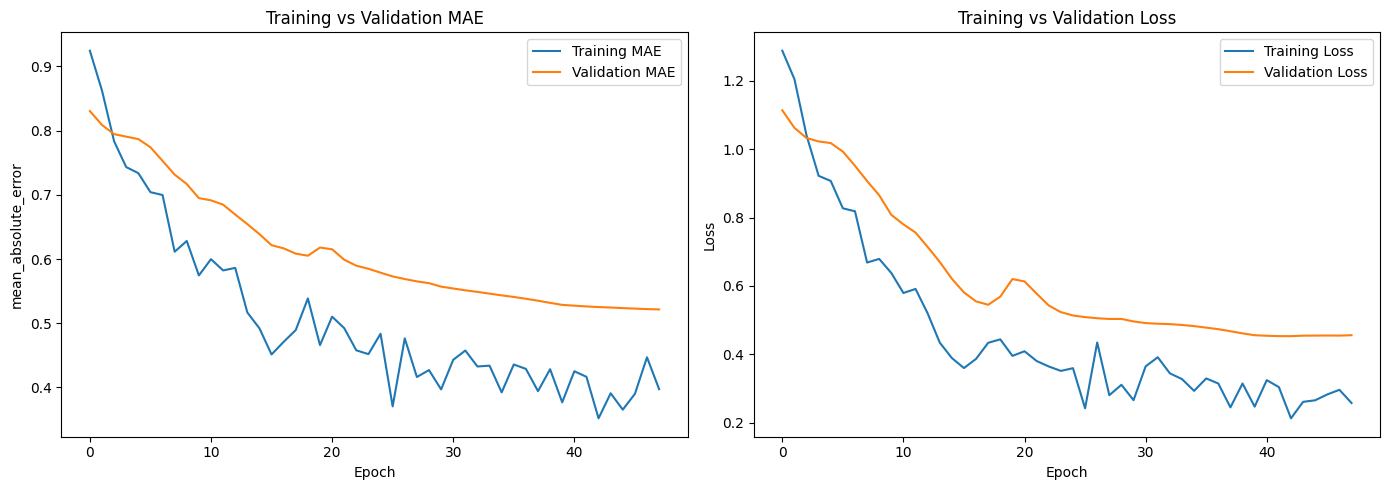

In [7]:
import matplotlib.pyplot as plt

# Assume 'history' is the object returned by your call to model.fit(...)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.title('Training vs Validation MAE')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Extracting embeddings of players

In [8]:
# Direct reference to layer
player_embeddings = player_embedding.get_weights()[0]
print(player_embeddings.shape)  # (NUM_PLAYERS, PLAYER_EMB_DIM)

(31, 32)


### UMAP and visualizing players in 3D

In [9]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Generate test embeddings and labels (replace these with actual data)
np.random.seed(42)
# player_embeddings = np.random.rand(32, 32)
# labels = [f'{name}' for name in team_dict.values()]
labels_points = [f'Player {idx}:{name}' for idx, name in enumerate(player_strengths)]


# Embed to 3D
reducer = umap.UMAP(n_components=3, random_state=None, n_jobs=-1)
embeddings_3d = reducer.fit_transform(player_embeddings)

# Create interactive 3D scatter plot
fig = go.Figure(
    data=[go.Scatter3d(
        x=embeddings_3d[:, 0],
        y=embeddings_3d[:, 1],
        z=embeddings_3d[:, 2],
        mode='markers',
        marker=dict(
            size=7,
            color=player_strengths,       # Color by this array
            colorscale='Viridis',         # Choose a colorscale
            colorbar=dict(title='Strength'),
            opacity=0.8
        ),
        text=labels_points,          # Hover labels
        hoverinfo='text'
    )]
)

fig.update_layout(
    title="3D UMAP projection of player embeddings",
    width=1000,             # <-- Change this to your desired width in pixels
    height=800,  
    scene=dict(
        xaxis_title="UMAP-1",
        yaxis_title="UMAP-2",
        zaxis_title="UMAP-3"
    )
)

fig

### Calculate correlation of the embeddings with the original base strengths

In [10]:
import numpy as np
from scipy.stats import pearsonr

# Assuming these variables from your setup:
# player_strengths: numpy array of shape (num_players,)
# embeddings_3d: numpy array of shape (num_players, 3) -- UMAP 3D projections

num_players = player_strengths.shape[0]
correlations = []
print(player_strengths.shape)
print(embeddings_3d[:, 0].shape)
for dim in range(3):
    corr, p_value = pearsonr(embeddings_3d[:, dim], player_strengths)
    correlations.append((corr, p_value))
    print(f"Dimension {dim + 1} correlation with base strengths: r = {corr:.4f}, p-value = {p_value:.4g}")

# Optionally, compute average absolute correlation across all 3 dimensions
avg_abs_corr = np.mean([abs(c[0]) for c in correlations])
print(f"Average absolute correlation across 3 components: {avg_abs_corr:.4f}")

(31,)
(31,)
Dimension 1 correlation with base strengths: r = -0.2098, p-value = 0.2574
Dimension 2 correlation with base strengths: r = 0.1123, p-value = 0.5475
Dimension 3 correlation with base strengths: r = 0.0083, p-value = 0.9648
Average absolute correlation across 3 components: 0.1101
